# FC autoencoder for MNIST

My first experiment with autoencoders: a small network with fully connected layers to autoencode the MNIST data

## Imports

In [1]:
from fastai.vision.all import *

## Load data

In [2]:
path = untar_data(URLs.MNIST_TINY)

In [3]:
path/'training'

Path('/Users/bauville/.fastai/data/mnist_tiny/training')

In [4]:
mean = 33.31
std = 78.56748962402344

def label_func(o):
    img = image2tensor(Image.open(o))
    # img -= mean
    # img /= std
    
    tf = RandomCrop(28)
    img = tf(img)
    # img /= 255.0
    img = img.view(1,784).float()
    img /= 255.0
    return img

dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), RegressionBlock),
                   get_items=get_image_files, 
                   # splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
                   splitter=GrandparentSplitter(),
                   # item_tfms=[Resize([1,784])],
                   get_y=label_func,
                   get_x=label_func)

dls = dblock.dataloaders(path)


In [5]:
# dls.show_batch(max_n=9, figsize=(4,4))

## Create architecture

In [24]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784,128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9),
        )

        self.decoder = nn.Sequential(
            nn.Linear(9,18),
            nn.ReLU(),
            nn.Linear(18,36),
            nn.ReLU(),
            nn.Linear(36,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,784),
            # nn.ReLU(),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create Learner

In [25]:
learn = Learner(dls, AE(), loss_func=MSELossFlat())

In [26]:
# learn.lr_find()
learn.fit(5, lr=0.002)

epoch,train_loss,valid_loss,time
0,0.218451,0.193446,00:00
1,0.176148,0.082390,00:00
2,0.131959,0.069218,00:00
3,0.109161,0.066199,00:00
4,0.095430,0.065090,00:00


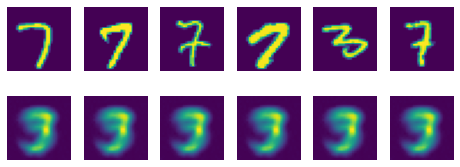

In [9]:
import torchvision.transforms as T
transform = T.ToPILImage()
b = dls.one_batch()
_,_,preds = learn.get_preds(dl=[b], with_decoded=True)
n = 6
fig, ax = plt.subplots(2,n, figsize= [8,3])
for i in range(n):
    # s = torch.randint(0,64,[]).item()
    s = i
    plt.axes(ax[0,i])
    plt.imshow(transform(b[1][s,:].view(28,28)))
    plt.axis('off')
    plt.axes(ax[1,i])
    plt.imshow(transform(preds[s,:].view(28,28)))
    plt.axis('off')


In [10]:
learn.model.encoder(b[1])

/Users/bauville/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1658300888192/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


tensor([[[-0.3764,  0.2736, -0.1443, -0.3846,  0.2001, -0.5132, -0.0728,
           0.0079,  0.0814]],

        [[-0.3907,  0.2885, -0.1395, -0.3951,  0.1992, -0.5321, -0.0890,
           0.0146,  0.0867]],

        [[-0.3858,  0.2836, -0.1422, -0.3922,  0.2014, -0.5236, -0.0841,
           0.0134,  0.0852]],

        [[-0.3780,  0.2759, -0.1470, -0.3895,  0.1999, -0.5126, -0.0732,
           0.0107,  0.0787]],

        [[-0.3885,  0.2843, -0.1399, -0.3937,  0.1970, -0.5271, -0.0818,
           0.0139,  0.0805]],

        [[-0.3774,  0.2758, -0.1446, -0.3869,  0.1993, -0.5154, -0.0732,
           0.0096,  0.0800]],

        [[-0.3795,  0.2796, -0.1435, -0.3912,  0.2020, -0.5185, -0.0788,
           0.0119,  0.0822]],

        [[-0.3758,  0.2735, -0.1433, -0.3820,  0.1991, -0.5139, -0.0726,
           0.0088,  0.0845]],

        [[-0.3794,  0.2765, -0.1404, -0.3854,  0.1997, -0.5194, -0.0753,
           0.0108,  0.0835]],

        [[-0.3952,  0.2910, -0.1364, -0.3954,  0.1976, -0.5360, 